<a href="https://colab.research.google.com/github/Shr11/student_career_recommendation_system/blob/main/student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json

def clean_metadata():
    from google.colab import _message
    contents = _message.blocking_request('get_ipynb')['ipynb']
    if 'metadata' in contents and 'widgets' in contents['metadata']:
        del contents['metadata']['widgets']
    _message.blocking_request('set_ipynb', request={'ipynb': contents})
    print("✅ Removed 'widgets' metadata from notebook.")

clean_metadata()


✅ Removed 'widgets' metadata from notebook.


In [ ]:
!pip install -q pandas scikit-learn openpyxl joblib

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score,recall_score
import joblib, warnings, os,io
warnings.filterwarnings('ignore')
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.stem import WordNetLemmatizer

In [ ]:
!pip install -q nltk

import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import files
uploaded = files.upload()

key, data = next(iter(uploaded.items()))
df_mendeley = pd.read_excel(io.BytesIO(data))[['Skill','Career']].dropna()

Saving Mendeley.xlsx to Mendeley.xlsx


In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)
display(df_mendeley.head(10))

,Skill,Career
0,"Web Development, Mobile App Development, Artificial Intelligence (AI) and Machine Learning, Problem Solving and Analysis, Cybersecurity, Operating Systems and Networking, Database Development, Data Analysis andVisualization, API Testing, Performance Testing, Statistical Analysis, ROLLING NOISE FILTER, Broadcast Journalism, Computer Network",Software Development and Engineering
1,"Web Development, Mobile App Development, Problem Solving and Analysis, Database Development",Development
2,"Data Analysis and Visualization, Deeplearning, Data Engineering, ProblemSolving, Communication, CriticalThinking",Data Science
3,Web Development,Development
4,"Deep Learning, Machine Learning, Statistics, Data Analysis and Visualization, deepelearning, Statistician, Data Analysis and Visualization, Research on Artificial Intelligence and Machine learning",Artificial Intelligence
5,"Web Development, Mobile App Development, Problem Solving and Analysis, Cybersecurity, Operating Systems and Networking, Database Development, Data Analysis and Visualization, System Design, Project Management, Cloud Computing, Communication, Critical Thinking, Interpersonal Skills, adaptability",Software Development and Engineering
6,"Data Analysis and Visualization, Critical Thinking, Interpersonal Skills, Feature Generation, Statistical Analysis",Data Science
7,"Web Development, Game Development, Cybersecurity, Web based project develop, Artificial Intelligence (AI) and Machine Learning",Software Development and Engineering
8,"Web Development, Web based project develop",Development
9,"Cloud Computing, Communication, Big Data Technologies, Feature Engineering, Classification",Data Science


In [ ]:
df_mendeley.shape

(4076, 2)

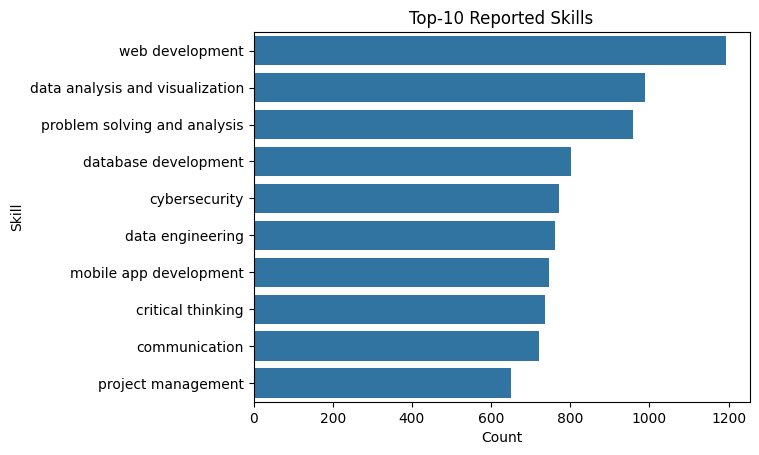

In [ ]:
skill_long = df_mendeley.assign(Skill_list=df['Skill'].str.split(',')) \
               .explode('Skill_list') \
               .assign(Skill_list=lambda d: d['Skill_list'].str.strip().str.lower())

top10 = (skill_long['Skill_list']
         .value_counts()
         .head(10)
         .rename_axis('Skill')
         .reset_index(name='Count'))

import seaborn as sns, matplotlib.pyplot as plt
sns.barplot(data=top10, x='Count', y='Skill')
plt.title('Top-10 Reported Skills')
plt.show()

In [ ]:
df_mendeley.isna().sum()

,0
Skill,0
Career,0


<Axes: xlabel='Career'>

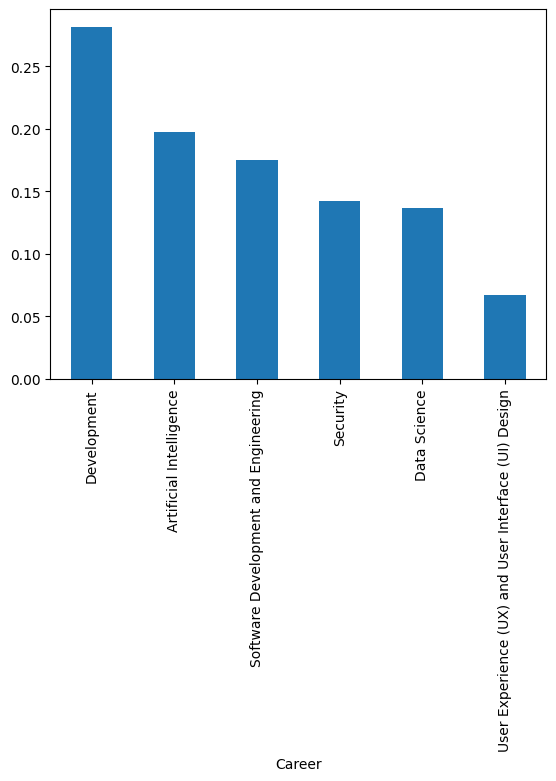

In [ ]:
df_mendeley['Career'].value_counts(normalize=True).plot.bar()

In [ ]:
career_counts = df_mendeley['Career'].value_counts()
print(career_counts)

print("\n=== Sample Skills (Raw) ===")
print(df_mendeley['Skill'].head(10))

print("\nTotal rows:", len(df_mendeley))

Career
Development                                            1148
Artificial Intelligence                                 804
Software Development and Engineering                    714
Security                                                580
Data Science                                            558
User Experience (UX) and User Interface (UI) Design     272
Name: count, dtype: int64

=== Sample Skills (Raw) ===
0    Web Development, Mobile App Development, Artificial Intelligence (AI) and Machine Learning, Problem Solving and Analysis, Cybersecurity, Operating Systems and Networking, Database Development, Data Analysis andVisualization, API Testing, Performance Testing, Statistical Analysis, ROLLING NOISE FILTER, Broadcast Journalism, Computer Network
1                                                                                                                                                                                                                                      

In [ ]:
SYNONYM_MAP = {
    'deeplearning': 'deep learning',
    'deep-learning': 'deep learning',
    'probsolving': 'problem solving',
    'andvisualization' : 'and visualization',
    'criticalthinking': 'critical thinking',
    'develop': 'development',
    'artificial intelligence ai and machine learning': 'artificial intelligence and machine learning'
}

NOISE_TOKENS = {'etc', 'na', 'none',"and", "with", "using", "in", "on", "for", "a", "an", "the"}

In [ ]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s,]', '', text)
    # Optionally remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tokenizer
def comma_skill_tokenizer(text):
    """
    Splits the entire string on commas,
    each comma-delimited phrase is a single token.
    """
    if not text:
        return []
    # Split on comma + optional spaces
    phrases = re.split(r',\s*', text.strip())
    # Remove empty tokens
    tokens = [p.strip() for p in phrases if p.strip()]
    return tokens

def apply_synonyms(text):
    """
    Replace known synonyms in the entire text using regex boundaries.
    E.g., 'deeplearning' -> 'deep learning'
    """
    for old, new in SYNONYM_MAP.items():
        # \b ensures word boundary; adjust if synonyms contain spaces
        text = re.sub(rf"\b{old}\b", new, text)
    return text

def remove_noise_tokens(text):
    """
    Remove noise words from the text. Since we still want to keep commas,
    we do a temporary split on whitespace, filter, then rejoin.
    """
    tokens = text.split()
    filtered = [t for t in tokens if t not in NOISE_TOKENS and len(t) > 1]
    return ' '.join(filtered)

def pipeline_text(text):
    """Apply all text processing steps in sequence"""
    text = clean_text(text)
    text = apply_synonyms(text)
    text = remove_noise_tokens(text)
    return text


#skipping since my data doesn't have many variations
# def lemmatize_tokens(tokens):
#     # Lemmatize each token. If tokens have spaces (like "deep learning"), you might either
#     # split them further or treat them as a phrase. We do a simple approach here:
#     # If you want to keep multi-word tokens, skip lemmatization for them or separate them first.

#     lemma_tokens = []
#     for t in tokens:
#         # If it is a multi-word phrase, e.g. "deep learning", we can do:
#         sub_words = t.split()
#         # lemmatize each sub_word
#         sub_words_lemma = [LEMMA.lemmatize(sw) for sw in sub_words]
#         # re-join them
#         lemma_phrase = " ".join(sub_words_lemma)
#         lemma_tokens.append(lemma_phrase)
#     return lemma_tokens

In [ ]:
df_mendeley['Skill_final'] = df_mendeley['Skill'].apply(pipeline_text)

In [ ]:
df_mendeley['Skill']

,Skill
0,"Web Development, Mobile App Development, Artificial Intelligence (AI) and Machine Learning, Problem Solving and Analysis, Cybersecurity, Operating Systems and Networking, Database Development, Data Analysis andVisualization, API Testing, Performance Testing, Statistical Analysis, ROLLING NOISE FILTER, Broadcast Journalism, Computer Network"
1,"Web Development, Mobile App Development, Problem Solving and Analysis, Database Development"
2,"Data Analysis and Visualization, Deeplearning, Data Engineering, ProblemSolving, Communication, CriticalThinking"
3,Web Development
4,"Deep Learning, Machine Learning, Statistics, Data Analysis and Visualization, deepelearning, Statistician, Data Analysis and Visualization, Research on Artificial Intelligence and Machine learning"
...,...
4071,"Deep Learning, Machine Learning, Data Engineering, Statistical Analyses, Data Analysis and Visualization, Critical Thinking, Artificial Intelligence and Machine learning,"
4072,"Graphic Design, UI/UX Knowledge"
4073,"Web Development, Mobile App Development, Problem Solving and Analysis"
4074,"Artificial Intelligence (AI) and Machine Learning, Problem Solving and Analysis, Cybersecurity, Operating Systems and Networking, Big Data Technologies, Project Management, Adaptability, Database Development, Data Analysis and Visualization, Data Engineering, System Design, Cloud Computing, Software Quality Assurance, Api testing"


In [ ]:
df_mendeley['Skill_clean']

,Skill_clean
0,"web development, mobile app development, artificial intelligence ai and machine learning, problem solving and analysis, cybersecurity, operating systems and networking, database development, data analysis andvisualization, api testing, performance testing, statistical analysis, rolling noise filter, broadcast journalism, computer network"
1,"web development, mobile app development, problem solving and analysis, database development"
2,"data analysis and visualization, deeplearning, data engineering, problemsolving, communication, criticalthinking"
3,web development
4,"deep learning, machine learning, statistics, data analysis and visualization, deepelearning, statistician, data analysis and visualization, research on artificial intelligence and machine learning"
...,...
4071,"deep learning, machine learning, data engineering, statistical analyses, data analysis and visualization, critical thinking, artificial intelligence and machine learning,"
4072,"graphic design, uiux knowledge"
4073,"web development, mobile app development, problem solving and analysis"
4074,"artificial intelligence ai and machine learning, problem solving and analysis, cybersecurity, operating systems and networking, big data technologies, project management, adaptability, database development, data analysis and visualization, data engineering, system design, cloud computing, software quality assurance, api testing"


In [ ]:
df_mendeley['Skill_phrases']

,Skill_phrases
0,[web development]
1,[web development]
2,[data analysis and visualization]
3,[web development]
4,[deep learning]
...,...
4071,[deep learning]
4072,[graphic design]
4073,[web development]
4074,[artificial intelligence ai and machine learning]


In [ ]:
df_mendeley["Skill_final"]

,Skill_final
0,"web development, mobile app development, artificial intelligence machine learning, problem solving analysis, cybersecurity, operating systems networking, database development, data analysis visualization, api testing, performance testing, statistical analysis, rolling noise filter, broadcast journalism, computer network"
1,"web development, mobile app development, problem solving analysis, database development"
2,"data analysis visualization, deep learning, data engineering, problemsolving, communication, critical thinking"
3,web development
4,"deep learning, machine learning, statistics, data analysis visualization, deepelearning, statistician, data analysis visualization, research artificial intelligence machine learning"
...,...
4071,"deep learning, machine learning, data engineering, statistical analyses, data analysis visualization, critical thinking, artificial intelligence machine learning,"
4072,"graphic design, uiux knowledge"
4073,"web development, mobile app development, problem solving analysis"
4074,"artificial intelligence machine learning, problem solving analysis, cybersecurity, operating systems networking, big data technologies, project management, adaptability, database development, data analysis visualization, data engineering, system design, cloud computing, software quality assurance, api testing"


In [ ]:
# Vectorizing (with TF-IDF)

X = df_mendeley['Skill_final']
y = df_mendeley['Career']


label_encoder= LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
career_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Career Mapping:")
for career, code in career_mapping.items():
    print(f"{code}: {career}")

Career Mapping:
0: Artificial Intelligence
1: Data Science
2: Development
3: Security
4: Software Development and Engineering
5: User Experience (UX) and User Interface (UI) Design


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 3260 samples
Test set: 816 samples


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=comma_skill_tokenizer,
        token_pattern=None,
        lowercase=False,
        ngram_range=(1,1),  # each comma block is 1 token
        min_df=3,
        sublinear_tf=True
    )),
    ('lr', LogisticRegression(
        C=1.0,
        solver='lbfgs',
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=1000
    ))
])

In [ ]:
param_grid = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__solver': ['lbfgs', 'saga'],  # saga handles L1/L2 and large data
    'lr__penalty': ['l2'],            # try 'l1' with 'saga' if sparse
    'lr__max_iter': [500, 1000, 2000]
}

grid_lr = GridSearchCV(
    pipeline, param_grid,
    scoring='recall_macro',  # focusing on recall
    cv=3, n_jobs=-1
)

grid_lr.fit(X_train, y_train)
print(f"Best params: {grid_lr.best_params_}")
print(f"Best recall (macro avg): {grid_lr.best_score_:.4f}")

best_model_lr = grid_lr.best_estimator_

Best params: {'lr__C': 10, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Best recall (macro avg): 0.9295


In [ ]:
tfidf = best_model_lr.named_steps['tfidf']
lr = best_model_lr.named_steps['lr']

In [ ]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
def display_top_features(vectorizer, n=10):
    feature_names = vectorizer.get_feature_names_out()
    print(f"Sample of top {n} feature names: {feature_names[:n]}")

display_top_features(tfidf, n=10)

Sample of top 10 feature names: ['adaptability' 'adaptability to new idea' 'adaptable' 'adaptibility'
 'adaption' 'administration' 'adobe photoshop' 'ai ml knowledge'
 'analytics' 'android app developing']


In [ ]:
print(X_train_tfidf.toarray())
print(tfidf.get_feature_names_out()[:25])

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.1525119 0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
['adaptability' 'adaptability to new idea' 'adaptable' 'adaptibility'
 'adaption' 'administration' 'adobe photoshop' 'ai ml knowledge'
 'analytics' 'android app developing' 'android app development'
 'android application development' 'api knowledge' 'api testers'
 'api testing' 'api testings' 'article writing' 'artificial intelligence'
 'artificial intelligence ai'
 'artificial intelligence ai andmachine learning'
 'artificial intelligence ai machine learning'
 'artificial intelligence machine learning'
 'artificial intelligence mathematics' 'artificialintelligence ai'
 'artistic expre

In [ ]:
y_test_decoded = label_encoder.inverse_transform(y_test)

# y_pred is already in string format — use it directly
print("\n=== Classification Report ===")
print(classification_report(
    y_test_decoded, y_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))


=== Classification Report ===
                                                     precision    recall  f1-score   support

                            Artificial Intelligence       0.91      0.94      0.93       161
                                       Data Science       0.92      0.96      0.94       112
                                        Development       0.94      0.96      0.95       230
                                           Security       0.95      0.91      0.93       116
               Software Development and Engineering       0.94      0.85      0.89       143
User Experience (UX) and User Interface (UI) Design       0.96      1.00      0.98        54

                                           accuracy                           0.93       816
                                          macro avg       0.94      0.94      0.94       816
                                       weighted avg       0.93      0.93      0.93       816



In [ ]:
# single sample probability example
sample_idx = 0
proba = lr.predict_proba(X_test_tfidf[sample_idx])
print(f"\nSkills: {X_test.iloc[sample_idx]}")
print(f"True career: {label_encoder.classes_[y_test[sample_idx]]}")
print("\nPrediction probabilities (top 3):")
top3 = sorted(zip(label_encoder.classes_, proba[0]), key=lambda x: x[1], reverse=True)[:3]
for career, prob in top3:
    print(f"{career}: {prob:.4f}")


Skills: artificial intelligence ai
True career: Artificial Intelligence

Prediction probabilities (top 3):
Artificial Intelligence: 0.9915
Software Development and Engineering: 0.0047
Security: 0.0020


In [ ]:
from xgboost import XGBClassifier
import numpy as np

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=comma_skill_tokenizer,
        token_pattern=None,
        lowercase=False,
        ngram_range=(1, 2),  # allow some bigram token matching
        min_df=2,
        sublinear_tf=True
    )),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        scale_pos_weight=1,
        num_class=len(np.unique(y_train)),
        random_state=42
    ))
])

param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1, 0.3]
}

grid = GridSearchCV(
    pipeline, param_grid,
    scoring='recall_macro',
    cv=3, n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best macro recall:", grid.best_score_)


Best params: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best macro recall: 0.937126868124832


In [ ]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Recall for 'SDE' class
sde_index = list(label_encoder.classes_).index("Software Development and Engineering")
recall_per_class = recall_score(y_test, y_pred, average=None)
print(f"\n Recall for 'SDE': {recall_per_class[sde_index]:.4f}")

=== Classification Report ===
                                                     precision    recall  f1-score   support

                            Artificial Intelligence       0.92      0.96      0.94       161
                                       Data Science       0.94      0.94      0.94       112
                                        Development       0.93      0.97      0.95       230
                                           Security       0.95      0.92      0.93       116
               Software Development and Engineering       0.93      0.84      0.88       143
User Experience (UX) and User Interface (UI) Design       0.98      1.00      0.99        54

                                           accuracy                           0.94       816
                                          macro avg       0.94      0.94      0.94       816
                                       weighted avg       0.94      0.94      0.93       816


 Recall for 'SDE': 0.8392


In [ ]:
import joblib

# Saving Logistic Regression pipeline
joblib.dump(best_model_lr, 'best_model_lr.joblib')

# Saving XGBoost pipeline
joblib.dump(best_model, 'best_model_xgb.joblib')

# Saving the label encoder (used for y encoding/decoding)
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [ ]:
joblib.dump(tfidf, "vectorizer.joblib")

['vectorizer.joblib']

In [ ]:
# best_model_lr = joblib.load('best_model_lr.joblib')
# best_model = joblib.load('best_model_xgb.joblib')
# label_encoder = joblib.load('label_encoder.joblib')

# # Example: using best_model_lr
# y_pred = best_model_lr.predict(X_new)  # for cocubes
# decoded_preds = label_encoder.inverse_transform(y_pred)

In [ ]:
!pip install --upgrade pip
!pip install --no-cache-dir transformers datasets torch scikit-learn


from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report

)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_ds = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
val_ds = Dataset.from_dict({'text': X_val.tolist(),   'label': y_val.tolist()})


tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=512)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)


model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_encoder.classes_)
)


#  metrics for training evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_macro': f1
    }


#  training arguments
training_args = TrainingArguments(
    output_dir="./results_distilbert",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs_distilbert',
    logging_steps=100,
    save_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="recall_macro"
)


# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()


# Evaluating on validation set
predictions = trainer.predict(val_ds)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

print("\n DistilBERT Classification Report")
print(classification_report(
    true_labels,
    preds,
    target_names=label_encoder.classes_,
    zero_division=0
))


trainer.save_model("distilbert_career_model")
tokenizer.save_pretrained("distilbert_career_tokenizer")
print("Model and tokenizer saved to 'distilbert_career_model' and 'distilbert_career_tokenizer'")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 286.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 308.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 271.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 351.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 232.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 258.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 238.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 245.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 238.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/3260 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_mendeley.to_csv("/content/drive/MyDrive/mendeley_processed.csv", index=False)

Mounted at /content/drive


In [ ]:
# finetuning

import pandas as pd
from google.colab import files

# Upload the files first
uploaded = files.upload()

def read_cocubes_cleaned_excel(file_name):
    # Step 1: Read all sheets and try to find the correct one
    xls = pd.ExcelFile(file_name)
    for sheet in xls.sheet_names:
        df_raw = xls.parse(sheet, header=None)
        for idx, row in df_raw.iterrows():
            if row.astype(str).str.contains("CoCubesId", na=False).any():
                header_row_idx = idx
                df_clean = pd.read_excel(file_name, sheet_name=sheet, header=header_row_idx)
                df_clean.dropna(axis=0, how='all', inplace=True)  # Drop empty rows
                df_clean.dropna(axis=1, how='all', inplace=True)  # Drop empty columns
                return df_clean
    raise ValueError(f"Header row with 'CoCubesId' not found in any sheet of {file_name}.")

# Load both Excel files
df_2025 = read_cocubes_cleaned_excel("CoCubes_2025.xlsx")
df_2026 = read_cocubes_cleaned_excel("CoCubes_2026.xlsx")

# Show info
print("2025 DataFrame shape:", df_2025.shape)
print("2026 DataFrame shape:", df_2026.shape)


Saving CoCubes_2025.xlsx to CoCubes_2025 (4).xlsx
Saving CoCubes_2026.xlsx to CoCubes_2026 (4).xlsx
2025 DataFrame shape: (94, 26)
2026 DataFrame shape: (202, 22)


In [ ]:
print("2025", df_2025.head(5))

2025    CoCubesId              Name     RollNumber                        Branch  \
0    3650904   Divyansh Dhiman  2102920100038  Computer Science Engineering   
1    3650928  Md Ashraf Ansari  2102920100062  Computer Science Engineering   
2    3650990        Ishika Pal  2102921540014  Computer Science Engineering   
3    3650980      Anjali Verma  2102921540004  Computer Science Engineering   
4    3940961           Md Saif       UG202202  Computer Science Engineering   

     Degree  Batch  Score/800  Aptitude  English  Quantitative  ...  \
0  B. Tech.   2025        682        87      100            87  ...   
1  B. Tech.   2025        624        78       87            80  ...   
2  B. Tech.   2025        623        71       80            73  ...   
3  B. Tech.   2025        609        71       93            80  ...   
4  B. Tech.   2025        605        67       87            67  ...   

         Analyst  Customer Service Executive  Graduate Engineer (Plant)  \
0     Good to go  

In [ ]:
print("2026", df_2026.head(5))

2026    CoCubesId              Name     RollNumber  \
0    4027403  Akshay Kumar Ram  2202920100014   
1    4027509   Vanshika Saxena  2202920100121   
2    4027516      Aditya Mehta  2202921530002   
3    4027491   Saurav Upadhyay  2202920100103   
4    4027566       Ishika Jain  2202921540022   

                                       Branch, Degree  Batch  Score/800  \
0              Computer Science Engineering, B. Tech.   2026        591   
1              Computer Science Engineering, B. Tech.   2026        568   
2  Artificial Intelligence and Data Science, B. Tech.   2026        564   
3              Computer Science Engineering, B. Tech.   2026        556   
4              Computer Science Engineering, B. Tech.   2026        550   

   Aptitude  English  Quantitative  Analytical  ...  Coding  Written English  \
0        71       87            47          80  ...      45               42   
1        64       67            60          67  ...      10               68   
2        

In [ ]:
df_2025 = df_2025.rename(columns={"RollNumber": "Roll No"})
df_2026 = df_2026.rename(columns={"RollNumber": "Roll No"})

In [ ]:
df_2025.columns

Index(['CoCubesId', 'Name', 'Roll_No', 'Branch', 'Degree', 'Batch',
       'Score/800', 'Aptitude', 'English', 'Quantitative', 'Analytical',
       'Domain', 'Computer_Fundamental', 'Coding', 'Written_English',
       'Personality', 'Analyst', 'Customer_Service_Executive',
       'Graduate_Engineer_(Plant)', 'Graduate_Engineer_(R&D)',
       'Network_Engineer', 'Operations_Executive', 'Sales_Executive',
       'Software_Developer', 'Software_Engineer', 'Software_Tester'],
      dtype='object')

In [ ]:
df_2026.columns = df_2026.columns.str.strip().str.replace(",", "_").str.replace(" ", "_")
df_2026 = df_2026.drop(columns=["CoCubes_Scores_&_Recommendations"], errors="ignore")


print(df_2026.columns)

Index(['CoCubesId', 'Name', 'Roll_No', 'Branch_Degree', 'Batch', 'Score/800',
       'Aptitude', 'English', 'Quantitative', 'Analytical', 'Domain',
       'Computer_Fundamental', 'Coding', 'Written_English', 'Personality',
       'Analytical.1', 'Quantitative.1', 'English.1', 'Domain.1',
       'Computer_Fundamentals', 'Coding.1', 'WET'],
      dtype='object')


In [ ]:
# Standardize column names
df_2025.columns = df_2025.columns.str.strip().str.replace(" ", "_").str.replace(",", "")
df_2026.columns = df_2026.columns.str.strip().str.replace(" ", "_").str.replace(",", "")

common_columns = [
     'Name', 'Roll No', 'CoCubesId',
    'Branch', 'Degree', 'Batch', 'Score_800', 'Aptitude', 'English', 'Quantitative',
    'Analytical', 'Coding', 'WET', 'Software_Developer', 'Software_Engineer', 'Software_Tester',
    'Analytical.1', 'Quantitative.1', 'English.1', 'Domain.1', 'Computer_Fundamentals'
]

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
# mapping

READINESS_MAP = {
"Good to go": 2,
"Need practice": 1,
"Need training": 0
}

ROLE_TO_MENDELEY_MAP = {
"Analyst": "Data Science",
"Customer_Service_Executive": "User Experience (UX) and User Interface (UI) Design",
"Graduate_Engineer_(Plant)": "Software Development and Engineering",
"Graduate_Engineer_(R&D)": "Software Development and Engineering",
"Network_Engineer": "Security",
"Operations_Executive": "Development",
"Sales_Executive": "Development", # for now
"Software_Developer": "Software Development and Engineering",
"Software_Engineer": "Software Development and Engineering",
"Software_Tester": "Software Development and Engineering"
}


In [ ]:
def convert_readiness_to_numeric(status: str) -> int:
    """
    Converts 'Good to go', 'Need practice', 'Need training' → 2,1,0.
    Returns 0 if not recognized.
    """
    return READINESS_MAP.get(status, 0)

def get_best_role(row):
    """
    Given a row with multiple role columns, convert readiness to numeric
    and pick the role (column) with the highest readiness.
    If there's a tie, returns the first encountered.
    """
    # Make sure both variables are created at the start of the function
    best_role = None
    best_readiness = -1

    # Loop over every role in ROLE_TO_MENDELEY_MAP
    for role_col in ROLE_TO_MENDELEY_MAP.keys():
        # Safely get the readiness string from the row
        readiness_str = row.get(role_col, "")

        # Convert to a numeric score
        readiness_val = convert_readiness_to_numeric(readiness_str)

        # If this readiness beats the current best, update
        if readiness_val > best_readiness:
            best_readiness = readiness_val
            best_role = role_col

    return best_role

def map_role_to_mendeley(role_col_name: str) -> str:
    """
    Maps that role column name (e.g., 'Software_Engineer')
    to a Mendeley career label (e.g., 'Software Development and Engineering').
    """
    if not role_col_name:
        return "Unknown"
    return ROLE_TO_MENDELEY_MAP.get(role_col_name, "Unknown")

def preprocess_2025_data(df):
    """
    1. Finds the 'best' role per row using get_best_role.
    2. Maps that role to a Mendeley-style label.
    3. Returns df with a new column called 'Mapped_Career'.
    """
    # Create a column "Best_Role" for each row
    df["Best_Role"] = df.apply(get_best_role, axis=1)
    # Map that role to a Mendeley label
    df["Mapped_Career"] = df["Best_Role"].apply(map_role_to_mendeley)
    return df

In [ ]:
df_2025.shape

(94, 26)

In [ ]:
df_2025.head(5)

,CoCubesId,Name,Roll_No,Branch,Degree,Batch,Score/800,Aptitude,English,Quantitative,...,Graduate_Engineer_(Plant),Graduate_Engineer_(R&D),Network_Engineer,Operations_Executive,Sales_Executive,Software_Developer,Software_Engineer,Software_Tester,Best_Role,Mapped_Career
0,3650904,Divyansh Dhiman,2102920100038,Computer Science Engineering,B. Tech.,2025,682,87,100,87,...,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Analyst,Data Science
1,3650928,Md Ashraf Ansari,2102920100062,Computer Science Engineering,B. Tech.,2025,624,78,87,80,...,Good to go,Good to go,Good to go,Good to go,Good to go,Need practice,Good to go,Good to go,Analyst,Data Science
2,3650990,Ishika Pal,2102921540014,Computer Science Engineering,B. Tech.,2025,623,71,80,73,...,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Analyst,Data Science
3,3650980,Anjali Verma,2102921540004,Computer Science Engineering,B. Tech.,2025,609,71,93,80,...,Need training,Need training,Need training,Need training,Need training,Need training,Need training,Need training,Analyst,Data Science
4,3940961,Md Saif,UG202202,Computer Science Engineering,B. Tech.,2025,605,67,87,67,...,Need training,Need training,Need training,Need training,Need training,Need training,Need training,Need training,Customer_Service_Executive,User Experience (UX) and User Interface (UI) Design


In [ ]:
df_2025 = preprocess_2025_data(df_2025)
print("After preprocessing:", df_2025.shape)

After preprocessing: (94, 28)


In [ ]:
df_2025.head(5)

,CoCubesId,Name,Roll_No,Branch,Degree,Batch,Score/800,Aptitude,English,Quantitative,...,Graduate_Engineer_(Plant),Graduate_Engineer_(R&D),Network_Engineer,Operations_Executive,Sales_Executive,Software_Developer,Software_Engineer,Software_Tester,Best_Role,Mapped_Career
0,3650904,Divyansh Dhiman,2102920100038,Computer Science Engineering,B. Tech.,2025,682,87,100,87,...,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Analyst,Data Science
1,3650928,Md Ashraf Ansari,2102920100062,Computer Science Engineering,B. Tech.,2025,624,78,87,80,...,Good to go,Good to go,Good to go,Good to go,Good to go,Need practice,Good to go,Good to go,Analyst,Data Science
2,3650990,Ishika Pal,2102921540014,Computer Science Engineering,B. Tech.,2025,623,71,80,73,...,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Good to go,Analyst,Data Science
3,3650980,Anjali Verma,2102921540004,Computer Science Engineering,B. Tech.,2025,609,71,93,80,...,Need training,Need training,Need training,Need training,Need training,Need training,Need training,Need training,Analyst,Data Science
4,3940961,Md Saif,UG202202,Computer Science Engineering,B. Tech.,2025,605,67,87,67,...,Need training,Need training,Need training,Need training,Need training,Need training,Need training,Need training,Customer_Service_Executive,User Experience (UX) and User Interface (UI) Design


In [ ]:
# Numeric features to use as input
numeric_features = [
    "Aptitude",
    "English",
    "Quantitative",
    "Analytical",
    "Domain",
    "Computer_Fundamental",
    "Coding",
    "Written_English"
]

df_2025_filtered = df_2025.dropna(subset=numeric_features)

X = df_2025_filtered[numeric_features]           # the feature matrix
y = df_2025_filtered["Mapped_Career"]           # Single-label career output

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (94, 8)
y shape: (94,)


In [ ]:
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42
    #stratify=y_encoded
)

print("Train shape:", X_train_25.shape, "Test shape:", X_test_25.shape)

Train shape: (75, 8) Test shape: (19, 8)


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
pipeline_cocubes_2025 = Pipeline([
    ("scaler", StandardScaler()),  # to Normalize numeric columns
    ("lr", LogisticRegression(
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=1000
    ))
])

pipeline_cocubes_2025.fit(X_train_25, y_train_25)

train_accuracy = pipeline_cocubes_2025.score(X_train_25, y_train_25)
test_accuracy = pipeline_cocubes_2025.score(X_test_25, y_test_25)

In [ ]:
lr_train_acc = pipeline_cocubes_2025.score(X_train_25, y_train_25)
lr_test_acc = pipeline_cocubes_2025.score(X_test_25, y_test_25)

lr_preds = pipeline_cocubes_2025.predict(X_test_25)

print("─── Logistic Regression Results ───")
print(f"Training Accuracy: {lr_train_acc:.3f}")
print(f"Test Accuracy: {lr_test_acc:.3f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test_25, lr_preds))

─── Logistic Regression Results ───
Training Accuracy: 0.853
Test Accuracy: 0.842

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.00      0.00      0.00         0
           2       1.00      0.83      0.91         6
           3       0.00      0.00      0.00         0
           4       0.80      0.80      0.80         5

    accuracy                           0.84        19
   macro avg       0.56      0.50      0.53        19
weighted avg       0.95      0.84      0.89        19



In [ ]:
joblib.dump(pipeline_cocubes_2025, "logreg_pipeline_2025.joblib")

['logreg_pipeline_2025.joblib']

In [ ]:
# loaded_pipeline = joblib.load("logreg_pipeline.joblib")

In [ ]:
from xgboost import XGBClassifier

pipeline_xgb = Pipeline([
("scaler", StandardScaler()),
("xgb", XGBClassifier(
use_label_encoder=False, # since XGBoost 1.0.2, to silence a warning
eval_metric="mlogloss",
random_state=42
))
])

pipeline_xgb.fit(X_train_25, y_train_25)

xgb_train_acc = pipeline_xgb.score(X_train_25, y_train_25)
xgb_test_acc = pipeline_xgb.score(X_test_25, y_test_25)
xgb_preds = pipeline_xgb.predict(X_test_25)

print("─── XGBoost Results ───")
print(f"Training Accuracy: {xgb_train_acc:.3f}")
print(f"Test Accuracy: {xgb_test_acc:.3f}")
print("\nClassification Report (XGBoost):")
print(classification_report(y_test_25, xgb_preds))

─── XGBoost Results ───
Training Accuracy: 1.000
Test Accuracy: 0.737

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           2       1.00      0.67      0.80         6
           4       0.67      0.40      0.50         5

    accuracy                           0.74        19
   macro avg       0.78      0.69      0.70        19
weighted avg       0.77      0.74      0.72        19



In [ ]:
joblib.dump(pipeline_xgb, "xgb_2025_pipeline.joblib")

['xgb_2025_pipeline.joblib']

In [ ]:
# tuning needed..
# • Using early stopping (like XGB’s built-in eval_set parameter).
# • Lowering max_depth, n_estimators, or learning_rate.
# • Adding L1/L2 regularization.
# • Increasing the size or diversity of your training data.


In [ ]:
for i, label_str in enumerate(label_encoder.classes_):
  print(f"Class {i} → {label_str}")

Class 0 → Data Science
Class 1 → Development
Class 2 → Security
Class 3 → Software Development and Engineering
Class 4 → User Experience (UX) and User Interface (UI) Design
